In [304]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_log_error
import seaborn as sns

In [305]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

num_cols = list(train.select_dtypes([float, 'int64']).columns)
num_cols.remove('SalePrice')
num_cols.remove('Id')

In [306]:
train.corrwith(train['SalePrice']).abs().sort_values()[::-1]  

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float

In [307]:
train[num_cols] = (train[num_cols] - train[num_cols].mean())/train[num_cols].std()
test[num_cols] = (test[num_cols] - test[num_cols].mean())/test[num_cols].std()

In [308]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [309]:
train.isna().mean()[train.isna().mean()!=0]

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [310]:
train = train.fillna(train.median())
test = test.fillna(train.median())

In [311]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [312]:
train

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,...,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.073350,-0.207948,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.509840,0.575228,-0.288554,-0.944267,-0.459145,-0.793162,1.161454,-0.120201,0.370207,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.911897,-0.950901,0.992066,0.311618,0.350880,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,0.138730,208500,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,-0.872264,0.409724,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.572637,1.171591,-0.288554,-0.641008,0.466305,0.257052,-0.794891,-0.120201,-0.482347,-0.819684,3.947457,0.789470,-0.761360,0.163723,-0.211381,-0.318574,0.600289,-0.101506,0.311618,-0.060710,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.06866

In [313]:
train = train[list(train.columns[train.columns.isin(list(test.columns))]) + ['SalePrice']]
test = test[test.columns[test.columns.isin(list(train.columns))]]
train.index = list(range(len(train)))

In [314]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [315]:
x = train.drop(columns = ['SalePrice', 'Id'])
y = train['SalePrice']
kf = KFold(n_splits=5)
kf.get_n_splits(train)

5

In [316]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [317]:
models = []

for i, (train_index, test_index) in enumerate(kf.split(x)):
    x_train = x.loc[train_index]
    x_test = x.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]
    
    lr = Lasso().fit(x_train, y_train)
    models.append(lr)
    print('MSE:', mean_squared_error(y_test, lr.predict(x_test)))
    print('MAE:', mean_absolute_error(y_test, lr.predict(x_test)))
    print('RMSEL:', mean_squared_log_error(y_test, np.abs(lr.predict(x_test))))
    print('\n')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2430706714.4016113, tolerance: 759214014.2531197
  positive)


MSE: 1213763732.5278542
MAE: 19801.300884068776
RMSEL: 0.06270745892752051




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20609630568.212708, tolerance: 728773513.025937
  positive)


MSE: 1326054589.6117399
MAE: 21607.30239973019
RMSEL: 0.05113421140458956




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49621455677.94879, tolerance: 699031751.5199751
  positive)


MSE: 1524944514.2101636
MAE: 21602.06724702642
RMSEL: 0.05788307753321162




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22760565383.507812, tolerance: 770619031.1834062
  positive)


MSE: 696430350.7293358
MAE: 17875.498254717397
RMSEL: 0.02472454949444416


MSE: 2583628839.641863
MAE: 20171.402116778496
RMSEL: 0.029126370874551825




/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25821132418.625183, tolerance: 724930391.3116124
  positive)


In [318]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [319]:
len(test)

1459

In [320]:
pred = np.zeros(len(test))
for m in models:
    pred += m.predict(test[x.columns])
pred = pred/len(models)

In [321]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [322]:
test['SalePrice'] = pred

In [323]:
test[['Id', 'SalePrice']].to_csv('sub_test.csv', index = False)

In [324]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [325]:
sample_submission = pd.read_csv ("sample_submission.csv")

In [326]:
pd.options.display.max_columns = 200

In [327]:
test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,...,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_GasA,Heating_GasW,Heating_Grav,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1461,-0.874411,0.510333,0.363804,-0.750844,0.400629,-0.340828,-1.072517,-0.566973,0.063251,0.516994,-0.650173,-0.370554,-0.654337,-0.774988,-0.080456,-1.215171,-0.818725,-0.25826,-1.028367,-0.750782,-1.029190,-0.20384,-0.918020,-0.897747,-0.632632,-0.987335,1.185131,0.366553,-0.701387,-0.360615,-0.088796,1.818336,-0.057207,-0.092212,-0.038268,1.713318,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,111426.586556
1,1462,-0.874411,0.555022,0.897553,-0.054858,0.400629,-0.439544,-1.214492,0.041046,1.062663,-0.297698,-0.339145,0.638706,0.433150,-0.774988,-0.080456,-0.323429,-0.818725,-0.25826,-1.028367,1.237224,0.175937,-0.20384,-0.255283,-0.897747,-0.746135,-0.987335,-0.740704,2.347063,-0.178765,-0.360615,-0.088796,-0.30

In [328]:
train[["OverallQual"]].dtypes

OverallQual    float64
dtype: object

In [329]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [330]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [331]:
train['SalePriceLog'] =  np.log1p(train['SalePrice'])
train['OverallQualLog'] =  np.log1p(train['OverallQual']+5)
test['OverallQualLog'] =  np.log1p(test['OverallQual']+5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [332]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

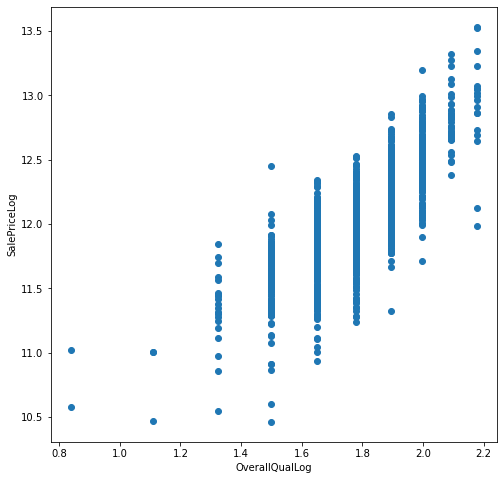

In [333]:
plt.figure(figsize= (8,8))
plt.scatter( train['OverallQualLog'], train['SalePriceLog'])
plt.xlabel('OverallQualLog')
plt.ylabel('SalePriceLog')
plt.show()

In [334]:
kf = KFold(n_splits=5)
kf.get_n_splits(train)

5

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

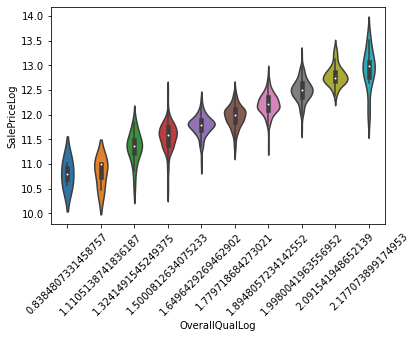

In [335]:
sns.violinplot(data = train, x ='OverallQualLog', y ='SalePriceLog')
plt.xticks(rotation=45)

In [336]:
train.isna().mean()[train.isna().mean()!=0]

Series([], dtype: float64)

In [337]:
print(kf)
rmse_list = []
models_list = []
for i, (train_index, test_index) in enumerate(kf.split(train)):
    
    X_train, X_test = train.loc[train_index, ['OverallQualLog']], train.loc[test_index, ['OverallQualLog']]
    y_train, y_test = train.loc[train_index, 'SalePriceLog'], train.loc[test_index, 'SalePriceLog']
    model = SGDRegressor()
    model.fit(X_train, y_train)
    models_list.append(model)
    predict = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(predict,y_test))
    rmse_list.append(rmse)
    print(i, rmse)
    
print("Mean rmse for 5-fold: {}".format(str(np.mean(rmse_list))))
print("std rmse for 5-fold: {}".format(str(np.std(rmse_list))))

KFold(n_splits=5, random_state=None, shuffle=False)
0 0.42176601023264715
1 0.5100675031924599
2 0.4396703061847926
3 0.48322323729938543
4 0.4731892727910381
Mean rmse for 5-fold: 0.4655832659400646
std rmse for 5-fold: 0.031430242362125244


In [338]:
models_list

[SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.01, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='squared_loss', max_iter=1000,
              n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.01, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='squared_loss', max_iter=1000,
              n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False),
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.01, fit_intercept=True, l1_ratio=0.15,
              learning_rate='invscaling', loss='squa

In [339]:
preds = np.zeros(len(test))
for m in models_list:
  preds += m.predict(test[X_train.columns])
preds/=len(models_list)

In [340]:
test['SalePrice'] = np.exp(preds) 
test[['Id', 'SalePrice']].to_csv('sub_test.csv', index = False)